# Looking for Malicious Users Through Apache Log Analysis

### Introduction
The inspiration for this project was to determine if/how malicous users could be identified by using machine learning tools to analyze Apache Web Server Logs. 

For this exercise, I use the freely-available Apache log samples available from NASA for one of their web servers from 1995. I'll start by identifying the kinds of data in the log file then isolate the activity on the site by user and perform [n-gram](https://en.wikipedia.org/wiki/N-gram) analysis to categorize new users as being 'typical' or 'a-typical'. The presumption is that 'a-typical' users would need to be analyzed further to determine if they were malicious. 

### Licence
This work is licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)
![CC BY 4.0](https://licensebuttons.net/l/by/3.0/88x31.png)

This license lets you distribute, remix, tweak, and build upon this work, even commercially, as long as you credit me, Robert Watkins, for the original creation. This is the most accommodating of licenses offered. Recommended for maximum dissemination and use of licensed materials.

### Data Dictionary
Using additional analysis not included in this notebook, I was able to come up with this data dictionary to describe the contents of the data file.

 | Column     | Description |
 |------------|:-----------:|
 | host       | The hostname or IP address making the request to the website |
 | logname    | not a populated field |
 | time       | integer version of unix timestamp |
 | method     | HTTP method for the call |
 | url        | path to the file being requested |
 | response   | HTTP response code for the call |
 | bytes      | Number of bytes returned for the request |
 | referer    | not a populated field |
 | useragent  | not a populated field |

---

### Prerequisites for this Python Notebook
 - python 3.x
 - python packages
   - pip3 install pandas
   - pip3 install scikit-learn
   - pip3 install matplotlib
   - pip3 install networkx
   - pip3 install hdbscan
   - pip3 install seaborn
 - jupyter notebook --debug > log.file 2>&1
 - mac users will need to install command-line tools for x-code
    xcode-select --install
 
### Sample data used for analysis
- http://indeedeng.github.io/imhotep/files/nasa_19950801.tsv (saved in 'rawData/nasa_19950801.tsv')
- http://indeedeng.github.io/imhotep/files/nasa_19950630.22-19950728.12.tsv.gz (Training Data)
- http://indeedeng.github.io/imhotep/files/nasa_19950731.22-19950831.22.tsv.gz (Testing Data)

### Import necessary libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math
import hashlib 
import networkx as nx
import itertools
import hdbscan
import seaborn as sns
import scipy as sp
from sklearn.metrics.pairwise import pairwise_distances

### Read data file

In [3]:
apache_log_path = 'rawData/nasa_19950801.tsv'
apache_log_data = pd.read_csv(apache_log_path, sep='\t', header=0)

### Extract navigation path for most active user
This was found earlier to be 'edams.ksc.nasa.gov'. We've hard-coded that value here.

In [4]:
visitor_address = apache_log_data.host
histogram_visitor_address = visitor_address.value_counts()
most_active_user_logs = apache_log_data.loc[apache_log_data['host'] == 'edams.ksc.nasa.gov']
most_active_user_path = most_active_user_logs['url']

### Create directed graph of single user's path to visualize the data
The bi-graph shows all the pairs of a path, the current node and the next node. This is ideal for defining a directed graph. While we will be using n-grams of a larger 'n' for our analysis, these bi-grams are useful for vor visualization.

We have our own home-grown function to create n-grams that omits information on the start and end of a user's path, but it will serve our needs for now. The 'tuple' version is for graphing and the 'dataframe' version is to make it a bit easier to read in column form.

In [5]:
#should unwind this a bit to make the purpose more clear
#also, there should be padding added to the front/back to indicate beginning and ending of a path
def find_ngrams(input_list, n):
  return [list(x) for x in set(tuple(x) for x in list(zip(*[input_list[i:] for i in range(n)])))]

most_active_user_path_bi_gram_as_tuples = list(find_ngrams(most_active_user_path,2))
labels=["node1","node2"]
most_active_user_path_bi_gram_as_dataframe = pd.DataFrame.from_records(most_active_user_path_bi_gram_as_tuples, columns=labels)
print(most_active_user_path_bi_gram_as_dataframe)

                           node1                         node2
0     /images/ksclogo-medium.gif                     /ksc.html
1    /images/WORLD-logosmall.gif    /images/NASA-logosmall.gif
2     /images/NASA-logosmall.gif    /images/ksclogo-medium.gif
3                      /ksc.html                     /ksc.html
4     /images/ksclogo-medium.gif    /images/NASA-logosmall.gif
5     /images/ksclogo-medium.gif  /images/MOSAIC-logosmall.gif
6      /images/USA-logosmall.gif   /images/WORLD-logosmall.gif
7                   /\\yahoo.com                     /ksc.html
8    /images/WORLD-logosmall.gif                     /ksc.html
9    /images/WORLD-logosmall.gif                  /\\yahoo.com
10                /htbin/wais.pl                     /ksc.html
11   /images/WORLD-logosmall.gif                /htbin/wais.pl
12                     /ksc.html    /images/ksclogo-medium.gif
13                     /ksc.html    /images/NASA-logosmall.gif
14  /images/MOSAIC-logosmall.gif     /images/USA-logosm

### Most Active User's Path Through the Site Converted to a Directed Graph
We take the bi-grams (in tuple form) and feed it into our graphing method. The labels muddle the graph a bit, but the structure seems pretty simple.

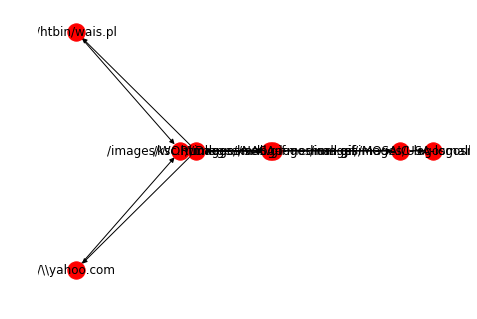

In [6]:
most_active_user_graph = nx.DiGraph()
most_active_user_graph.add_edges_from(most_active_user_path_bi_gram_as_tuples)
nx.draw_spectral(most_active_user_graph, arrows=True, with_labels=True)

### Now, let's look at the graph for the second most active user
We see from earlier analysis (not listed here) that it's the IP address '130.110.74.81'. This structure is certainly different, but it looks like there are some straightforward paths through the site that this user takes.

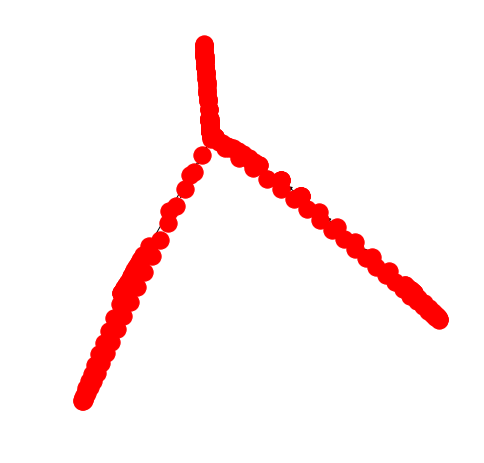

In [7]:
#get just the entries from the second most active user
second_most_active_user_logs = apache_log_data.loc[apache_log_data['host'] == '130.110.74.81']
#get a list of just the URLs for that user
second_most_active_user_path = second_most_active_user_logs['url']
#create bi-gram for graph
second_most_active_user_path_bi_gram = list(find_ngrams(second_most_active_user_path,2))
#generate graph 
second_most_active_user_graph = nx.DiGraph()
second_most_active_user_graph.add_edges_from(second_most_active_user_path_bi_gram)
plt.figure(3,figsize=(6,6)) 
nx.draw_spectral(second_most_active_user_graph, arrows=True, with_labels=False)  

### Let's look at the generic case. 
We can get the graph for a particular user by specifying the index of user from the histogram table (choose an index less than 2365 for this dataset). Note the various structures of each user as you re-run the code after changing the index. 

Note: Since the n-gram function doesn't consider the beginning and end of a users path through the system, the users that requested a single element from the server will not show any graph because there is not enough data. Additional, users with an index larger than about 1900 in this dataset will not show useful graphs because they are essentially very small. Once the n-gram function is corrected, each user would have a graph showing the start and end nodes and the single element the user requested.

www.gsi.fr


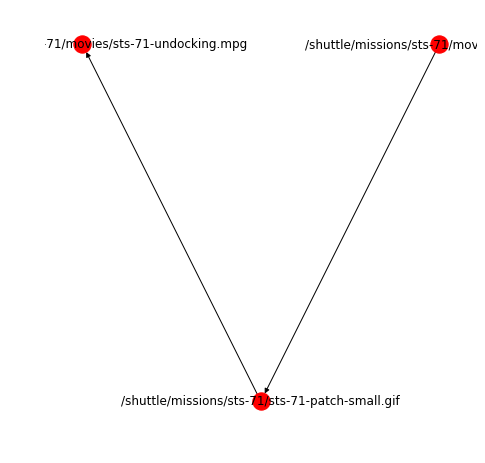

In [8]:
#Change this value from 1 to 2364 for this datasset
#Most interesting data is for values between 1 and 1900
index_to_graph = 1900

#Code to get data for this index
visitor_addresses = apache_log_data.host
histogram_visitor_address = visitor_addresses.value_counts()
visitor_address = histogram_visitor_address.index[index_to_graph]
print(visitor_address)

#get just the entries from the second most active user
nth_most_active_user_logs = apache_log_data.loc[apache_log_data['host'] == visitor_address]
#get a list of just the URLs for that user
nth_most_active_user_path = nth_most_active_user_logs['url']

#create bi-gram for graph
nth_most_active_user_path_bi_gram = list(find_ngrams(nth_most_active_user_path,2))
#generate graph
nth_most_active_user_graph = nx.DiGraph()
nth_most_active_user_graph.add_edges_from(nth_most_active_user_path_bi_gram)
plt.figure(3,figsize=(6,6)) 
nx.draw_spectral(nth_most_active_user_graph,  arrows=True, with_labels=True)


# Now What?
If we presume that the patterns we've seen so far hold for the general case, we could surmise that the pattern of a user is an arc of usage that follows long sequences of requests and occasionally re-visiting previously visited elements.

### The Next Experiment

Ultimately, we are interested in determining if a pattern of usage for a new visitor looks 'typical' or 'a-typical'. In this case, we have existing usage that we will presume to be 'typical'. One common approach, which we'll be using, is the idea of 'clustering' our data. We need to group our usage of the system into usage where each usage of the system in the same group is close to each other. For a measure of 'closeness', we rely on being able to have a distance metric we can calculate.

In this experiment, we'll calculate clusters using the [Levenshtein Distance](https://en.wikipedia.org/wiki/Levenshtein_distance) also known as the 'edit distance' to compare a new path observed by a user to existing paths by other users. The Levenshtein Distance is called the 'edit distance' because it measures the number of edits it would take to change the first sequence to the second sequence. 

Rather than compare the full sequences of users' paths through the server to calculate the distance, we'll compare n-grams. It's not clear what choice of 'n' would be useful, so there will need to be some effort expended to choose a suitable 'n'.

We'll correspondingly have a point at which we determine where the minimum Levenshtein Distance classifies the new sequence as 'typical' or 'a-typical'.

This will result in having an optimized set of clusters and a corresponding configuration parameters to generate these clusters.

### The Primary Challenge
We don't have a good way to generate 'a-typcial' data in this case. So we're left at guessing a bit at what conditions will trigger an 'a-typical' categorization. Hopefully, using my current experience of how vulnerabiltiy-seeking tools and techniques work, I can come up with a sufficient variety of 'a-typical' calls to be able to test the model. 

Another challenge is that I'm not including any 'a-typical' data in my training. Any 'a-typical' behavior detected would be as a result of the user's path the system deviating sufficiently from normal navigation of the system and not from any other metadata.

### Define the Levenschtein Distance for ordered lists of requested urls

We are fortunate to have a well-established distance formula available to caluate the 'distance' between two sequences of urls to determine how similar they are. One slight drawback is that there is no common library to calculate the levenschtein distance for a general orderd list of elements.

The internet comes to the rescue to provide some tips on [rolling your own function](https://medium.com/@yash_agarwal2/soundex-and-levenshtein-distance-in-python-8b4b56542e9e) to perform this task.

In [9]:
def get_levenshtein_distance(path1, path2):
    """
    https://en.wikipedia.org/wiki/Levenshtein_distance
    :param path1:
    :param path2:
    :return:
    """
    matrix = [[0 for x in range(len(path2) + 1)] for x in range(len(path1) + 1)]

    for x in range(len(path1) + 1):
        matrix[x][0] = x
    for y in range(len(path2) + 1):
        matrix[0][y] = y

    for x in range(1, len(path1) + 1):
        for y in range(1, len(path2) + 1):
            if path1[x - 1] == path2[y - 1]:
                matrix[x][y] = min(
                    matrix[x - 1][y] + 1,
                    matrix[x - 1][y - 1],
                    matrix[x][y - 1] + 1
                )
            else:
                matrix[x][y] = min(
                    matrix[x - 1][y] + 1,
                    matrix[x - 1][y - 1] + 1,
                    matrix[x][y - 1] + 1
                )

    return matrix[len(path1)][len(path2)]

#### Sample use of Levenshstein Distance
Let's start with 3 different 5-grams. These represent 5 ordered requests from the site. You can see the initial list has 5 requests to the root of the web server. The next shows 4 requests the root and then an image and the last shows 3 requests to the root an then two different images.

In [10]:
sample_n_gram_list = [['/', '/', '/', '/', '/'], 
                      ['/', '/', '/', '/', '/images/ksclogosmall.gif'], 
                      ['/', '/', '/', '/images/ksclogo-medium.gif', '/images/MOSAIC-logosmall.gif']]

---
The Levenshtein distance between a list and itself should be 0 

In [11]:
get_levenshtein_distance(sample_n_gram_list[1],sample_n_gram_list[1])

0

---
The distance between the first two lists should be 1

In [12]:
get_levenshtein_distance(sample_n_gram_list[1],sample_n_gram_list[0])

1

---
The distance between the first and last lists should be 2

In [13]:
get_levenshtein_distance(sample_n_gram_list[0],sample_n_gram_list[2])

2

### Clustering Methodology
While the k-means clustering is seen as the de-facto standard for clustering, we won't be able to use it because it relies on the Euclidian space (using real numbers to identify points in the space). Our distance formula is strictly integer-based, so we need a [different approach](https://www.datascience.com/blog/k-means-alternatives).

We'll be using [HDBSCAN](https://www.theoj.org/joss-papers/joss.00205/10.21105.joss.00205.pdf) in the hopes that it provides a strong process to identify clusters from the noise and serves as a good method to distinquish 'a-typical' usage'

Additionally, in contrast to our earlier analysis where we used a single day's worth of data to generate n-grams, for this experiment, we'll generate n-grams from a month's worth of data as our training data. Then we will generate n-grams from a month's worth of testing data and calcualte the minimum Levenshtein Distance for each n-gram in the hopes that we can identify the threshold where the distance is large enough to be classified as 'a-typical'.

#### A few data formatting hoops
The implementation of HDBSCAN library I'm using only accepts numbers to perform it's calculations, so each url in our n-gram will need to be replaced with a unique numeric identifier. To achieve that, I'll create a url id map and functions to translate the n-grams back and forth from url to id.


In [14]:
# get list of unique urls to get unique id.
unique_urls_as_set = set(apache_log_data['url'])
unique_urls_as_list = list(unique_urls_as_set)
unique_urls_as_array = np.array(unique_urls_as_list)
unique_url_map = pd.DataFrame(unique_urls_as_array, columns={"url"})
#print(unique_url_map.head())

In [15]:
# functions to convert to/from id and url
def get_id_from_url(url):
    return unique_url_map.index[unique_url_map['url'] == url][0]

def get_url_from_id(id):
    return unique_url_map.loc[id,'url']


# show how to convert from url to id and from id to url
#print("Samples converting to/from urls and ids")
#print("URL with id 0 = " , get_url_from_id(0))
#print("id of url '/' = ", get_id_from_url('/'))

#convert n-gram from urls to ids
def n_gram_to_id (n_gram_of_urls):
    n_gram_of_ids = list(n_gram_of_urls)
    for i in range(0, len(n_gram_of_urls)):
        n_gram_of_ids[i] = get_id_from_url(n_gram_of_urls[i])
    return n_gram_of_ids

#convert n-grams from ids to urls
def n_gram_to_url (n_gram_of_ids):
    n_gram_of_urls = list(n_gram_of_ids)
    for i in range(0, len(n_gram_of_ids)):
        n_gram_of_urls[i] = get_url_from_id(n_gram_of_ids[i])
    return n_gram_of_urls

#convert list of n-grams from urls to ids
def n_gram_list_to_ids (n_gram_list_of_urls):
    n_gram_list_of_ids = list(n_gram_list_of_urls)
    for i in range(0, len(n_gram_list_of_urls)):
        n_gram_list_of_ids[i] = n_gram_to_id(n_gram_list_of_urls[i])
    return n_gram_list_of_ids

#convert list of n-grams from ids to urls
def n_gram_list_to_urls (n_gram_list_of_ids):
    n_gram_list_of_urls = list(n_gram_list_of_ids)
    for i in range(0, len(n_gram_list_of_ids)):
        n_gram_list_of_urls[i] = n_gram_to_url(n_gram_list_of_ids[i])
    return n_gram_list_of_urls

#sample_n_gram = sample_n_gram_list[0]
#print("sample ngram :", sample_n_gram)
#print("sample ngram to id :", n_gram_to_id(sample_n_gram))

#print("Starting ngram :", sample_n_gram_list)

#sample_n_gram_list_as_ids = n_gram_list_to_ids(sample_n_gram_list)
#print("Converted to ngram of ids :", sample_n_gram_list_as_ids)

#print("Can it be converted back? ", sample_n_gram_list==n_gram_list_to_urls(sample_n_gram_list_as_ids))

### Create Distance Matrix from n-gram of ids

In [16]:
sample_n_gram_list_as_ids = n_gram_list_to_ids(sample_n_gram_list)
distance_matrix = pairwise_distances(sample_n_gram_list_as_ids, metric=get_levenshtein_distance)

print("Distance Matrix: \n", distance_matrix)
print("n-gram list :", sample_n_gram_list)

Distance Matrix: 
 [[0. 1. 2.]
 [1. 0. 2.]
 [2. 2. 0.]]
n-gram list : [['/', '/', '/', '/', '/'], ['/', '/', '/', '/', '/images/ksclogosmall.gif'], ['/', '/', '/', '/images/ksclogo-medium.gif', '/images/MOSAIC-logosmall.gif']]


### Identify all the unique n-grams
We've set aside the size of the n-grams so that we can experiment with what value this will need to be.

In [17]:
#set value of 'n' for n-gram
n = 5

# Read Training Data
training_data_path = 'rawData/nasa_19950630.22-19950728.12.tsv'
training_data = pd.read_csv(apache_log_path, sep='\t', header=0)

#Sort unique users by number of requests made to the web server
visitor_addresses = training_data.host
histogram_visitor_address = visitor_addresses.value_counts()

# start with empty n-gram list
ith_most_active_user_path_n_gram = list()

for row in histogram_visitor_address.iteritems():
    visitor = row[0]
    #print(visitor)
    #get just the entries from the second most active user
    ith_most_active_user_logs = training_data.loc[training_data['host'] == visitor]
    #get a list of just the URLs for that user
    ith_most_active_user_path = ith_most_active_user_logs['url']

    #create n-gram for graph
    ith_most_active_user_path_n_gram.extend(list(find_ngrams(ith_most_active_user_path,n)))
    
    #remove duplicates
    ith_most_active_user_path_n_gram.sort()
    ith_most_active_user_path_n_gram = list(ith_most_active_user_path_n_gram for ith_most_active_user_path_n_gram,_ in itertools.groupby(ith_most_active_user_path_n_gram))

print("First 3 n-grams :\n",ith_most_active_user_path_n_gram[:3])

First 3 n-grams :
 [['/', '/', '/', '/', '/'], ['/', '/', '/', '/', '/images/ksclogosmall.gif'], ['/', '/', '/', '/images/ksclogo-medium.gif', '/images/MOSAIC-logosmall.gif']]


### Cluster n-grams with HDBSCAN clustering and the Levenschtein Distance
The two adjustment knobs we have for these experiments is the n in the n-grams and the minimum cluster size for HDBSCAN. We'll modify these and see what the results look like.

In [18]:
#generate distance matrix, this could take quite a while
sample_n_gram_list_as_ids = n_gram_list_to_ids(ith_most_active_user_path_n_gram)
distance_matrix = pairwise_distances(sample_n_gram_list_as_ids, metric=get_levenshtein_distance)
print("Distance Matrix: \n", distance_matrix)

Distance Matrix: 
 [[0. 1. 2. ... 5. 5. 5.]
 [1. 0. 2. ... 5. 5. 5.]
 [2. 2. 0. ... 5. 5. 5.]
 ...
 [5. 5. 5. ... 0. 3. 4.]
 [5. 5. 5. ... 3. 0. 4.]
 [5. 5. 5. ... 4. 4. 0.]]


Now that we have the distance matrix calculate for our data, we'll be looping through the cluster sizes to try to find an optimal cluster size to minimize the number of clusters.

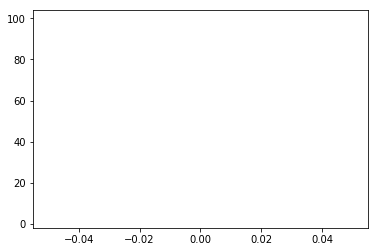

In [19]:
#This will take quite a while to run, maybe more than 45 minutes, depending on your system and data size.
for i in range(2,100):
    results = []
    clust_number = i
    clusterer = hdbscan.HDBSCAN(min_cluster_size=clust_number, metric='precomputed')
    clusterer.fit(distance_matrix)
    results.append([i,clusterer.labels_.max()])

plt.plot(results)

We see that the number of clusters seems to bottom out at 4 when the the cluster size is set to 53 and doesn't seem to improve after that. (Note: the graph is not labeled properly, the awkward way of reading it is to see the blue line represents the min cluster size and the orange line represents the number of clusters)

We'll set the cluster size to 53 and investigate further.

Max clusters 4


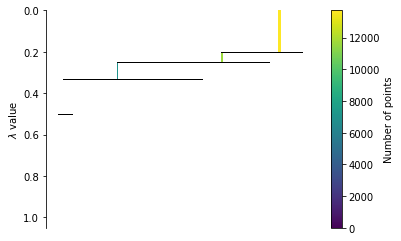

In [54]:
#generate clusters
clust_number = 53
clusterer = hdbscan.HDBSCAN(min_cluster_size=clust_number, metric='precomputed', gen_min_span_tree=True)
clusterer.fit(distance_matrix)
print("Max clusters", clusterer.labels_.max())
clusterer.condensed_tree_.plot()


### Outliers
Now that we have what we think is a good model for our cluster, let's look at outliers

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


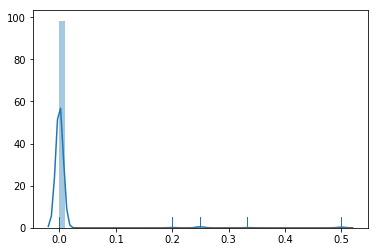

In [21]:
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

Let's look at the outliers

In [22]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
print(len(outliers)/len(sample_n_gram_list_as_ids)*100,"% of original data does not fit in a cluster")

1.639702667249672 % of original data does not fit in a cluster


### Prediction
Now that we have an understanding of our model, we are satisfied that it will provide useful data to continue. We can now predict where a new n-gram will fall, either as part of a cluster or as part of an outlier.


In [56]:
#this only works if the distance metric is not pre-computed, which we're using
#test_points_as_urls=[ ['/', '/', '/', '/images/ksclogo-medium.gif', '/images/MOSAIC-logosmall.gif']]
#test_points =  n_gram_list_to_ids(test_points_as_urls)
#test_labels, strengths = hdbscan.approximate_predict(clusterer, test_points)
#print("Guess for the clusters (or -1 for outlier)", test_labels)

#https://stackoverflow.com/questions/27822752/scikit-learn-predicting-new-points-with-dbscan
def dbscan_predict(dbscan_model, X_new, metric=get_levenshtein_distance):
    # Result is noise by default
    y_new = np.ones(shape=len(X_new), dtype=int)*-1 

    # Iterate all input samples for a label
    for j, x_new in enumerate(X_new):
        # Find a core sample closer than EPS
        for i, x_core in enumerate(dbscan_model.exemplars_): 
            if metric(x_new, x_core) < dbscan_model.eps:
                # Assign label of x_core to x_new
                y_new[j] = dbscan_model.labels_[dbscan_model.core_sample_indices_[i]]
                break

    return y_new

# A bit of a roadblock
In looking at the HDBSCAN usage, I don't think it's the best clustering algorithm to use. It allows for each cluster to use a different maximum distance by specifying the minimum size of the cluster. I think I want to set the maximum distance specifically since I am using a Levenschtein Distance, which returns integer values. 

### Experiment 2
Since there is some processor-intensive code on this page and that code is a useful description of this process, I'll start a [new page](ApacheNGram-Experiment2.ipynb) to continue this experiment